# Forecast stock price via regression using pycaret

In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import ipywidgets as widgets
import requests
import random
import time
import matplotlib.dates as mdates
import itertools

# Importing encoders
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Import for string manipulation
import nltk
import string
import re


# Time Series Imports
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pycaret.regression import *

# Model Evaluation Imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# To increase the visible rows & cols
pd.options.display.max_rows = 2500
pd.options.display.max_columns = 15000

### Data Import: Importing stocks data that we will be predicting

These are the stocks that we will be forecasting:

r/wallstreetbets:
1. GME
2. AMC
3. TSLA
4. META

r/investing:
1. GM
2. UBER
3. RIOT
4. AMD

In [438]:
# import the 10 year historical data of each stock

# r/wallstreetbets
gme_test_df = pd.read_csv('../data/gme1_historical.csv')
gme_df = pd.read_csv('../data/gme_historical.csv')
amc_df = pd.read_csv('../data/amc_historical.csv')
tsla_df = pd.read_csv('../data/tsla_historical.csv')
meta_df = pd.read_csv('../data/meta_historical.csv')

# r/investing
gm_df = pd.read_csv('../data/gm_historical.csv')
uber_df = pd.read_csv('../data/uber_historical.csv')
riot_df = pd.read_csv('../data/riot_historical.csv')
amd_df = pd.read_csv('../data/amd_historical.csv')

In [439]:
# Comment seems like there are $ signs in the data  which we will need to remove later on

gme_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,07/25/2023,$22.85,1671991,$23.10,$23.10,$22.53
1,07/24/2023,$23.04,2970433,$22.42,$23.04,$22.20
2,07/21/2023,$22.18,3167916,$23.05,$23.22,$22.16
3,07/20/2023,$22.91,2256659,$23.01,$23.22,$22.66
4,07/19/2023,$23.17,2250133,$23.42,$23.58,$22.96


In [440]:
gme_df.tail()

,Date,Close/Last,Volume,Open,High,Low
2511,08/01/2013,$12.495,16796516,$12.38,$12.84,$12.315
2512,07/31/2013,$12.265,18825016,$11.785,$12.38,$11.785
2513,07/30/2013,$11.7275,10822960,$11.3625,$11.8125,$11.36
2514,07/29/2013,$11.3475,7770952,$11.4175,$11.435,$11.1425
2515,07/26/2013,$11.45,10389824,$11.015,$11.4625,$10.9664


In [441]:
# Comment: There seems to be no null values here

gme_df.isnull().sum().sort_values(ascending = False)

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [442]:
# Doesnt seem to have any duplicated data either

print(gme_df[gme_df.duplicated()])

Empty DataFrame
Columns: [Date, Close/Last, Volume, Open, High, Low]
Index: []


In [443]:
# Will need to change the data type for price columns into float

gme_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2516 non-null   object
 1   Close/Last  2516 non-null   object
 2   Volume      2516 non-null   int64 
 3   Open        2516 non-null   object
 4   High        2516 non-null   object
 5   Low         2516 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [444]:
# To remove the $ sign and change the datatypes into float

def clean_data(df):
    for col in ["Close/Last", "Open", "High", "Low"]:
        df[col] = df[col].str.replace("$", "").astype(float)

In [445]:
clean_data(gme_test_df)
gme_test_df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_2496\2671839315.py:5: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



,Date,Close/Last,Volume,Open,High,Low
0,07/25/2023,22.85,1671991,23.10,23.10,22.53
1,07/24/2023,23.04,2970433,22.42,23.04,22.20
2,07/21/2023,22.18,3167916,23.05,23.22,22.16
3,07/20/2023,22.91,2256659,23.01,23.22,22.66
4,07/19/2023,23.17,2250133,23.42,23.58,22.96


For the purpose of price prediction, we will use VWAP as the price of stock

VWAP is defined as: Volume Weighted Average Price, it is a trading benchmark that represents the average price a security traded at throughout the day, based on both volume and price.

- VWAP = (Cumulative typical price * Volume) / Culmulative Volume
- Where: Typical Price = (High Price + Low Price + Closing Price)/3

In [446]:
# Create a function that adds a new column "VWAP" to the dataframe

def calc_vwap(df):
    df["Typical_Price"] = (df["High"] + df["Low"] + df["Close/Last"])/3
    df["VWAP"] = (np.cumsum(df["Volume"] * df["Typical_Price"]) / np.cumsum(df["Volume"])).round(2)
    return df


In [447]:
# Generate VWAP which will be the price we will use in the time series prediction

calc_vwap(gme_test_df)

,Date,Close/Last,Volume,Open,High,Low,Typical_Price,VWAP
0,07/25/2023,22.8500,1671991,23.1000,23.1000,22.5300,22.826667,22.83
1,07/24/2023,23.0400,2970433,22.4200,23.0400,22.2000,22.760000,22.78
2,07/21/2023,22.1800,3167916,23.0500,23.2200,22.1600,22.520000,22.68
3,07/20/2023,22.9100,2256659,23.0100,23.2200,22.6600,22.930000,22.73
4,07/19/2023,23.1700,2250133,23.4200,23.5800,22.9600,23.236667,22.83
...,...,...,...,...,...,...,...,...
2511,08/01/2013,12.4950,16796516,12.3800,12.8400,12.3150,12.550000,16.17
2512,07/31/2013,12.2650,18825016,11.7850,12.3800,11.7850,12.143333,16.17
2513,07/30/2013,11.7275,10822960,11.3625,11.8125,11.3600,11.633333,16.17
2514,07/29/2013,11.3475,7770952,11.4175,11.4350,11.1425,11.308333,16.17


In [448]:
# Make a function that ensures that 'Date' is in datatime format
gme_test_df['Date'] = pd.to_datetime(gme_test_df['Date'])

# Set Date as the index for
gme_test_df.set_index("Date", inplace = True)

# Reset the order of the date so that it is from oldest to most recent to help the model to predict 
gme_test_df = gme_test_df.sort_index(ascending=True)

# From now we will only use VWAP to predict the price of the stock, so we shall remove other unnecessary columns
gme_test_df = gme_test_df[['VWAP']]

# Resets any prevailing indexes of the DataFrame, and use the default one instead
gme_test_df = gme_test_df.reset_index()

<Axes: xlabel='Date'>

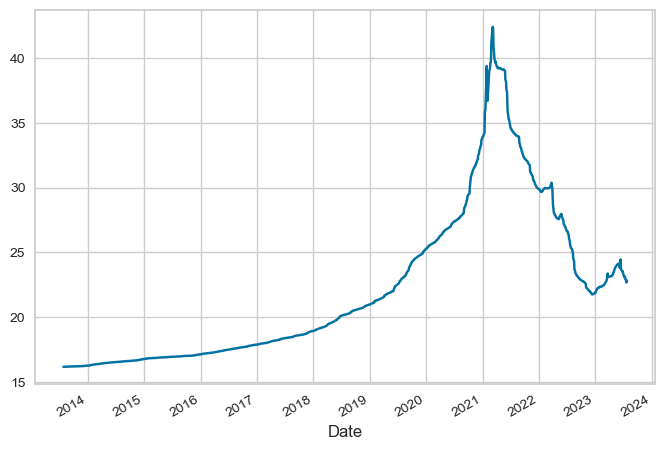

In [449]:
# gme_test_df['VWAP'].plot()
gme_test_df.set_index('Date').VWAP.plot()

### Building Multiple model using pycaret

In [450]:
# create 12 month moving average
gme_test_df['MA12'] = gme_test_df['VWAP'].rolling(12).mean()
# plot the data and MA
import plotly.express as px
fig = px.line(gme_test_df, x="Date", y=["VWAP", "MA12"], template = 'plotly_dark')
fig.show()

In [451]:
# extract month and year from dates
gme_test_df['Day'] = [i.day for i in gme_test_df['Date']]
gme_test_df['Month'] = [i.month for i in gme_test_df['Date']]
gme_test_df['Year'] = [i.year for i in gme_test_df['Date']]

# create a sequence of numbers
gme_test_df['Series'] = np.arange(1,len(gme_test_df)+1)

# drop unnecessary columns and re-arrange
gme_test_df.drop(['MA12'], axis=1, inplace=True)
gme_test_df = gme_test_df[['Date', 'Series', 'Year', 'Month', 'Day', 'VWAP']] 

# check the head of the dataset
gme_test_df.head()

,Date,Series,Year,Month,Day,VWAP
0,2013-07-26,1,2013,7,26,16.17
1,2013-07-29,2,2013,7,29,16.17
2,2013-07-30,3,2013,7,30,16.17
3,2013-07-31,4,2013,7,31,16.17
4,2013-08-01,5,2013,8,1,16.17


In [452]:
def train_test_split_timeseries(data, train_ratio=0.75):
    # Ensure the data is sorted by date if date column exists
    if 'Date' in data.columns:
        data.sort_values('Date', inplace=True)
        
    # Calculate the index at which to split
    split_index = int(len(data) * train_ratio)

    # Split the data
    train = data.iloc[:split_index]
    test = data.iloc[split_index:]

    return train, test


In [453]:
train, test = train_test_split_timeseries(gme_test_df)

In [454]:
# initialize setup
s = setup(data = train, test_data = test, target = 'VWAP', fold_strategy = 'timeseries', numeric_features = ['Year', 'Month', 'Day', 'Series'], fold = 3, transform_target = False, session_id = 123)

,Description,Value
0,Session id,123
1,Target,VWAP
2,Target type,Regression
3,Original data shape,"(2516, 6)"
4,Transformed data shape,"(2516, 8)"
5,Transformed train set shape,"(1887, 8)"
6,Transformed test set shape,"(629, 8)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


In [455]:
best_MAPE = compare_models(sort = 'MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,1.9659,10.2829,2.3657,-0.7354,0.0951,0.0774,0.0300
lr,Linear Regression,2.1602,12.6867,2.5197,-0.7218,0.1016,0.0840,1.2933
lar,Least Angle Regression,2.1661,12.6821,2.5289,-0.7464,0.1021,0.0843,1.0500
omp,Orthogonal Matching Pursuit,2.1764,12.8356,2.5267,-0.7195,0.1019,0.0846,0.0267
ridge,Ridge Regression,2.1775,12.8274,2.5282,-0.7247,0.1020,0.0847,1.0600
br,Bayesian Ridge,2.1791,12.8374,2.5303,-0.7284,0.1021,0.0847,0.0300
en,Elastic Net,2.1804,12.8514,2.5321,-0.7313,0.1022,0.0848,1.0333
lasso,Lasso Regression,2.1845,12.8672,2.5376,-0.7439,0.1025,0.0850,1.0733
llar,Lasso Least Angle Regression,2.1845,12.8672,2.5376,-0.7439,0.1025,0.0850,0.9967
gbr,Gradient Boosting Regressor,2.2340,12.7319,2.7526,-1.9214,0.1139,0.0892,0.0833


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [456]:
best_R2 = compare_models(sort = 'R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,2.1764,12.8356,2.5267,-0.7195,0.1019,0.0846,0.0267
lr,Linear Regression,2.1602,12.6867,2.5197,-0.7218,0.1016,0.0840,0.0367
ridge,Ridge Regression,2.1775,12.8274,2.5282,-0.7247,0.1020,0.0847,0.0300
br,Bayesian Ridge,2.1791,12.8374,2.5303,-0.7284,0.1021,0.0847,0.0333
en,Elastic Net,2.1804,12.8514,2.5321,-0.7313,0.1022,0.0848,0.0267
par,Passive Aggressive Regressor,1.9659,10.2829,2.3657,-0.7354,0.0951,0.0774,0.0300
lasso,Lasso Regression,2.1845,12.8672,2.5376,-0.7439,0.1025,0.0850,0.0300
llar,Lasso Least Angle Regression,2.1845,12.8672,2.5376,-0.7439,0.1025,0.0850,0.0333
lar,Least Angle Regression,2.1661,12.6821,2.5289,-0.7464,0.1021,0.0843,0.0300
huber,Huber Regressor,2.3496,14.6810,2.6878,-0.9193,0.1095,0.0914,0.0300


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [457]:
prediction_holdout = predict_model(best_R2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,6.1110,50.4439,7.1024,-0.4402,0.2331,0.2131


In [458]:
prediction_holdout.head()

,Date,Series,Year,Month,Day,VWAP,prediction_label
1887,2021-01-25,1888,2021,1,25,38.320000,26.313957
1888,2021-01-26,1889,2021,1,26,38.990002,26.320710
1889,2021-01-27,1890,2021,1,27,39.380001,26.327463
1890,2021-01-28,1891,2021,1,28,38.200001,26.334215
1891,2021-01-29,1892,2021,1,29,37.709999,26.340968


In [459]:
test.head()

,Date,Series,Year,Month,Day,VWAP
1887,2021-01-25,1888,2021,1,25,38.32
1888,2021-01-26,1889,2021,1,26,38.99
1889,2021-01-27,1890,2021,1,27,39.38
1890,2021-01-28,1891,2021,1,28,38.20
1891,2021-01-29,1892,2021,1,29,37.71


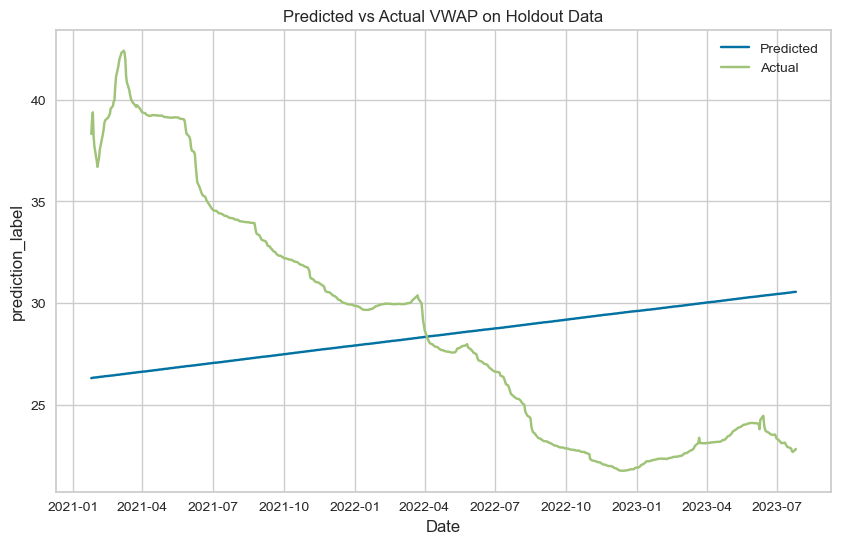

In [460]:
# To get the performance metrics of the model
predicted_holdout_metrics = pull()

# To plot the predictions
plt.figure(figsize=(10,6))
sns.lineplot(x = prediction_holdout['Date'], y = prediction_holdout['prediction_label'], label = 'Predicted')
sns.lineplot(x = prediction_holdout['Date'], y = prediction_holdout['VWAP'], label = 'Actual')
plt.title('Predicted vs Actual VWAP on Holdout Data')
plt.show()


In [461]:
predictions.head()

,Date,Series,Year,Month,Day,VWAP,prediction_label
0,2013-07-26,1,2013,7,26,0.245611,16.253812
1,2013-07-29,2,2013,7,29,0.245611,17.418124
2,2013-07-30,3,2013,7,30,0.245611,17.055356
3,2013-07-31,4,2013,7,31,0.245611,16.726146
4,2013-08-01,5,2013,8,1,0.245611,16.065370


In [462]:
# generate predictions on the original dataset
predictions = predict_model(best_R2, data=gme_test_df)
# line plot
fig = px.line(predictions, x='Date', y=["VWAP", "prediction_label"], template = 'plotly_dark')
# add a vertical rectange for test-set separation
fig.add_vrect(x0="2021-01-25", x1="2023-07-25", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.7228,15.6487,3.9558,0.5757,0.1388,0.1115


### Conclusion: None of the models produced here generates acceptable performance either